In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OrdinalEncoder
from pandas import DataFrame
from pandas import concat
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import class_weight
import seaborn as sns

In [25]:
house_data = pd.read_csv("../preprocessed_data/oneHot_data.csv")

In [26]:
house_data.head()

,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,Month,DayOfWeek,Day,HourofDay,...,T_stp_heat,Humidity,auxHeat1,fan,Thermostat_Temperature,Thermostat_Motion,Remote_Sensor_1_Temperature,Remote_Sensor_1_Motion,T_out,RH_out
0,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,1,0,...,0.663321,0.177458,0,11,0.330465,0.0,67.0,0.0,0.009112,1.808865
1,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,1,0,...,0.663321,0.177458,2,9,0.330465,0.0,67.0,0.0,0.009112,1.808865
2,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,1,0,...,0.663321,0.177458,20,20,0.330465,0.0,67.0,0.0,0.009112,1.808865
3,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,1,0,...,0.663321,0.177458,9,12,0.330465,0.0,67.0,0.0,0.009112,1.808865
4,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,1,0,...,0.663321,0.177458,0,8,0.330465,0.0,67.0,0.0,0.009112,1.808865


In [27]:
house_data.columns

Index(['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'Month', 'DayOfWeek', 'Day', 'HourofDay', 'HvacMode_heat', 'Event_Hold',
       'Event_None', 'Schedule_Away', 'Schedule_Home', 'Schedule_Sleep',
       'T_ctrl', 'T_stp_heat', 'Humidity', 'auxHeat1', 'fan',
       'Thermostat_Temperature', 'Thermostat_Motion',
       'Remote_Sensor_1_Temperature', 'Remote_Sensor_1_Motion', 'T_out',
       'RH_out'],
      dtype='object')

In [28]:
working_df = house_data[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]

In [29]:
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

In [30]:
working_df.head()

,T_ctrl,T_stp_heat,T_out,RH_out,auxHeat1
0,0.311691,0.663321,0.009112,1.808865,0
1,0.311691,0.663321,0.009112,1.808865,2
2,0.311691,0.663321,0.009112,1.808865,20
3,0.311691,0.663321,0.009112,1.808865,9
4,0.311691,0.663321,0.009112,1.808865,0


In [31]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# ANN Using Previous Time Steps

In [32]:
reframed = series_to_supervised(working_df, 6, 1)

In [33]:
reframed

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
6,0.311691,0.663321,0.009112,1.808865,0.0,0.311691,0.663321,0.009112,1.808865,2.0,...,0.311691,0.663321,0.009112,1.808865,0.0,0.311691,0.663321,0.075007,1.877919,0
7,0.311691,0.663321,0.009112,1.808865,2.0,0.311691,0.663321,0.009112,1.808865,20.0,...,0.311691,0.663321,0.075007,1.877919,0.0,0.311691,0.663321,0.075007,1.877919,0
8,0.311691,0.663321,0.009112,1.808865,20.0,0.311691,0.663321,0.009112,1.808865,9.0,...,0.311691,0.663321,0.075007,1.877919,0.0,0.311691,0.663321,0.075007,1.877919,14
9,0.311691,0.663321,0.009112,1.808865,9.0,0.311691,0.663321,0.009112,1.808865,0.0,...,0.311691,0.663321,0.075007,1.877919,14.0,0.311691,0.663321,0.075007,1.877919,19
10,0.311691,0.663321,0.009112,1.808865,0.0,0.311691,0.663321,0.009112,1.808865,0.0,...,0.311691,0.663321,0.075007,1.877919,19.0,0.311691,0.663321,0.075007,1.877919,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58832,0.311691,0.663321,-0.649837,-0.055597,10.0,0.311691,0.663321,-0.649837,-0.055597,20.0,...,0.311691,0.663321,-0.649837,-0.124651,0.0,0.311691,0.663321,-0.649837,-0.124651,0
58833,0.311691,0.663321,-0.649837,-0.055597,20.0,0.311691,0.663321,-0.649837,-0.055597,20.0,...,0.311691,0.663321,-0.649837,-0.124651,0.0,0.311691,0.663321,-0.649837,-0.124651,0
58834,0.311691,0.663321,-0.649837,-0.055597,20.0,0.311691,0.663321,-0.649837,-0.055597,9.0,...,0.311691,0.663321,-0.649837,-0.124651,0.0,0.311691,0.663321,-0.649837,-0.124651,0
58835,0.311691,0.663321,-0.649837,-0.055597,9.0,0.311691,0.663321,-0.649837,-0.055597,0.0,...,0.311691,0.663321,-0.649837,-0.124651,0.0,0.311691,0.663321,-0.649837,-0.124651,0


In [34]:
y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)

In [35]:
y_auxHeat

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [36]:
test = np.argmax(y_auxHeat, axis = 1)

In [37]:
(unique, counts) = np.unique(test, return_counts = True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[    0 42156]
 [    1   403]
 [    2   392]
 [    3   378]
 [    4   380]
 [    5   375]
 [    6   421]
 [    7   376]
 [    8   394]
 [    9   367]
 [   10   368]
 [   11   357]
 [   12   404]
 [   13   367]
 [   14   349]
 [   15   405]
 [   16   385]
 [   17   341]
 [   18   382]
 [   19   360]
 [   20  9471]]


In [38]:
class_weight = class_weight.compute_class_weight('balanced', classes = np.unique(test), y = test)

In [39]:
X = reframed.drop(labels = ["var5(t)"], axis = 1)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

In [41]:
print(X_train.shape, y_train.shape)

(47064, 34) (47064, 21)


In [42]:
np.unique(y_train)

array([0., 1.], dtype=float32)

In [44]:
smote = RandomUnderSampler(sampling_strategy = 'all')
X_train, y_train = smote.fit_sample(X_train, y_train)
print(X_train.shape, y_train.shape)

AttributeError: 'RandomUnderSampler' object has no attribute '_validate_data'

In [45]:
test = np.argmax(y_train, axis = 1)

In [46]:
(unique, counts) = np.unique(test, return_counts = True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[    0 33734]
 [    1   319]
 [    2   318]
 [    3   288]
 [    4   298]
 [    5   305]
 [    6   334]
 [    7   299]
 [    8   310]
 [    9   295]
 [   10   296]
 [   11   288]
 [   12   333]
 [   13   290]
 [   14   275]
 [   15   338]
 [   16   286]
 [   17   272]
 [   18   311]
 [   19   292]
 [   20  7583]]


In [64]:
np.unique(test)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20], dtype=int64)

In [20]:
X_train = X_train.values
X_test = X_test.values

In [21]:
y_train.shape

(47064, 21)

In [22]:
X_train.shape

(47064, 34)

In [23]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 50, shuffle = True, 
                         class_weight = class_weight)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

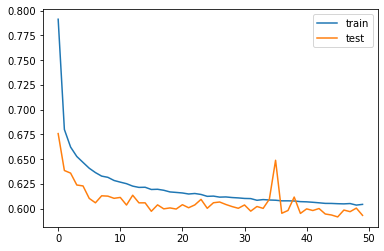

In [108]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

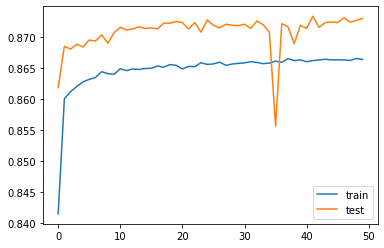

In [109]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [110]:
y_predicted = classifier.predict(X_test)

In [111]:
y_predicted = np.argmax(y_predicted, axis = 1)

In [112]:
y_predicted

array([ 0,  0, 20, ...,  0,  0,  0], dtype=int64)

In [113]:
y_test = np.argmax(y_test, axis = 1)

In [114]:
y_test

array([ 0,  0, 13, ...,  0,  0,  0], dtype=int64)

In [115]:
np.unique(y_predicted)

array([ 0,  2,  6,  9, 11, 19, 20], dtype=int64)

In [116]:
cm = confusion_matrix(y_test, y_predicted)

In [117]:
cfm_n = np.flipud(cm)
cfm_n = cfm_n.astype('float') / cfm_n.sum(axis=1)[:, np.newaxis]

z = np.round(cfm_n, 2)
#x = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
y = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
#y = ['20', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']
x = ['20', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']
#x = ['1', '0']
#y = ['0', '1']
fig = ff.create_annotated_heatmap(z, x = x, y = y, annotation_text = z, colorscale = 'deep')
fig.update_layout(width = 1600, height = 1600, xaxis_showgrid = False, yaxis_showgrid = False, template = 'none')
fig.update_layout(title = {'text': "",
                           'y':0.95,
                           'x':0.47,
                           'xanchor': 'center',
                           'yanchor': 'top'}, 
                  xaxis_title = 'Predicted Labels',
                  yaxis_title = 'True Labels')
fig['layout']['xaxis']['side'] = 'bottom'
fig.show()

In [118]:
test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

In [119]:
test_sum

762135

In [120]:
predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

In [121]:
predicted_sum

758700

In [122]:
print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))

Error Percentage in predicted values is : 0.4507075518116869 %


# Testing be3947e8e568396e84549fad714a9e59c82c579e

In [123]:
data = pd.read_csv("../preprocessed_data/std_test_data_be3947e8e568396e84549fad714a9e59c82c579e.csv")

In [124]:
data.drop(labels = ['index'], axis = 1, inplace = True)

In [125]:
data = data[cols]

In [126]:
reframed_test = series_to_supervised(data, 6, 1)

In [127]:
y_auxHeat_test = reframed_test['var5(t)']
y_auxHeat_test = to_categorical(y_auxHeat_test)

In [128]:
X_test_house = reframed_test.drop(labels = ["var5(t)"], axis = 1)

In [129]:
X_test_house = X_test_house.values

In [130]:
y_predicted_test = classifier.predict(X_test_house)

In [131]:
y_predicted_test = np.argmax(y_predicted_test, axis = 1)

In [132]:
y_predicted_test

array([ 0,  0,  0, ...,  0, 20, 20], dtype=int64)

In [133]:
y_auxHeat_test = np.argmax(y_auxHeat_test, axis = 1)

In [134]:
y_auxHeat_test

array([ 0,  0,  0, ..., 14, 20, 20], dtype=int64)

In [135]:
np.unique(y_predicted_test)

array([ 0,  8, 11, 17, 19, 20], dtype=int64)

In [136]:
cm = confusion_matrix(y_auxHeat_test, y_predicted_test)

In [137]:
cfm_n = np.flipud(cm)
cfm_n = cfm_n.astype('float') / cfm_n.sum(axis=1)[:, np.newaxis]

z = np.round(cfm_n, 2)
#x = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
y = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
#y = ['20', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']
x = ['20', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']
#x = ['1', '0']
#y = ['0', '1']
fig = ff.create_annotated_heatmap(z, x = x, y = y, annotation_text = z, colorscale = 'deep')
fig.update_layout(width = 1600, height = 1600, xaxis_showgrid = False, yaxis_showgrid = False, template = 'none')
fig.update_layout(title = {'text': "",
                           'y':0.95,
                           'x':0.47,
                           'xanchor': 'center',
                           'yanchor': 'top'}, 
                  xaxis_title = 'Predicted Labels',
                  yaxis_title = 'True Labels')
fig['layout']['xaxis']['side'] = 'bottom'
fig.show()

In [138]:
test_sum = 0
for i in range(len(y_auxHeat_test)):
    test_sum += (y_auxHeat_test[i] * 15)

In [139]:
test_sum

2466315

In [140]:
predicted_sum = 0
for i in range(len(y_predicted_test)):
    predicted_sum += (y_predicted_test[i] * 15)

In [141]:
predicted_sum

2715075

In [142]:
print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))

Error Percentage in predicted values is : 10.08630284452716 %


# Testing 675d186406d3bce54a44f51a346e94856dddb8a8

In [143]:
data = pd.read_csv("../preprocessed_data/std_test_data_675d186406d3bce54a44f51a346e94856dddb8a8.csv")

In [144]:
data.drop(labels = ['index'], axis = 1, inplace = True)

In [145]:
data = data[cols]

In [146]:
reframed_test = series_to_supervised(data, 6, 1)

In [147]:
y_auxHeat_test = reframed_test['var5(t)']
y_auxHeat_test = to_categorical(y_auxHeat_test)

In [148]:
X_test_house = reframed_test.drop(labels = ["var5(t)"], axis = 1)

In [149]:
X_test_house = X_test_house.values

In [150]:
y_predicted_test = classifier.predict(X_test_house)

In [151]:
y_predicted_test = np.argmax(y_predicted_test, axis = 1)

In [152]:
y_predicted_test

array([20, 20, 20, ..., 20, 20,  0], dtype=int64)

In [153]:
y_auxHeat_test = np.argmax(y_auxHeat_test, axis = 1)

In [154]:
y_auxHeat_test

array([ 0,  0, 15, ..., 20, 17,  0], dtype=int64)

In [155]:
np.unique(y_predicted_test)

array([ 0,  6, 10, 11, 14, 15, 17, 19, 20], dtype=int64)

In [156]:
cm = confusion_matrix(y_auxHeat_test, y_predicted_test)

In [157]:
cfm_n = np.flipud(cm)
cfm_n = cfm_n.astype('float') / cfm_n.sum(axis=1)[:, np.newaxis]

z = np.round(cfm_n, 2)
#x = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
y = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
#y = ['20', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']
x = ['20', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']
#x = ['1', '0']
#y = ['0', '1']
fig = ff.create_annotated_heatmap(z, x = x, y = y, annotation_text = z, colorscale = 'deep')
fig.update_layout(width = 1600, height = 1600, xaxis_showgrid = False, yaxis_showgrid = False, template = 'none')
fig.update_layout(title = {'text': "",
                           'y':0.95,
                           'x':0.47,
                           'xanchor': 'center',
                           'yanchor': 'top'}, 
                  xaxis_title = 'Predicted Labels',
                  yaxis_title = 'True Labels')
fig['layout']['xaxis']['side'] = 'bottom'
fig.show()

In [158]:
test_sum = 0
for i in range(len(y_auxHeat_test)):
    test_sum += (y_auxHeat_test[i] * 15)

In [159]:
test_sum

3394710

In [160]:
predicted_sum = 0
for i in range(len(y_predicted_test)):
    predicted_sum += (y_predicted_test[i] * 15)

In [161]:
predicted_sum

8299170

In [162]:
print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))

Error Percentage in predicted values is : 144.47360746573347 %


# Testing 7d3e3b8f5a29e01917c11417de021787b5dbf6be

In [163]:
data = pd.read_csv("../preprocessed_data/std_test_data_7d3e3b8f5a29e01917c11417de021787b5dbf6be.csv")

In [164]:
data.drop(labels = ['index'], axis = 1, inplace = True)

In [165]:
data = data[cols]

In [166]:
reframed_test = series_to_supervised(data, 6, 1)

In [167]:
y_auxHeat_test = reframed_test['var5(t)']
y_auxHeat_test = to_categorical(y_auxHeat_test)

In [168]:
X_test_house = reframed_test.drop(labels = ["var5(t)"], axis = 1)

In [169]:
X_test_house = X_test_house.values

In [170]:
y_predicted_test = classifier.predict(X_test_house)

In [171]:
y_predicted_test = np.argmax(y_predicted_test, axis = 1)

In [172]:
y_predicted_test

array([20, 20, 20, ...,  0,  0,  0], dtype=int64)

In [173]:
y_auxHeat_test = np.argmax(y_auxHeat_test, axis = 1)

In [174]:
y_auxHeat_test

array([20, 20, 20, ...,  0,  0,  0], dtype=int64)

In [175]:
np.unique(y_predicted_test)

array([ 0,  1,  2,  5,  6, 20], dtype=int64)

In [176]:
cm = confusion_matrix(y_auxHeat_test, y_predicted_test)

In [177]:
cfm_n = np.flipud(cm)
cfm_n = cfm_n.astype('float') / cfm_n.sum(axis=1)[:, np.newaxis]

z = np.round(cfm_n, 2)
#x = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
y = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
#y = ['20', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']
x = ['20', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']
#x = ['1', '0']
#y = ['0', '1']
fig = ff.create_annotated_heatmap(z, x = x, y = y, annotation_text = z, colorscale = 'deep')
fig.update_layout(width = 1600, height = 1600, xaxis_showgrid = False, yaxis_showgrid = False, template = 'none')
fig.update_layout(title = {'text': "",
                           'y':0.95,
                           'x':0.47,
                           'xanchor': 'center',
                           'yanchor': 'top'}, 
                  xaxis_title = 'Predicted Labels',
                  yaxis_title = 'True Labels')
fig['layout']['xaxis']['side'] = 'bottom'
fig.show()

In [178]:
test_sum = 0
for i in range(len(y_auxHeat_test)):
    test_sum += (y_auxHeat_test[i] * 15)

In [179]:
test_sum

2784720

In [180]:
predicted_sum = 0
for i in range(len(y_predicted_test)):
    predicted_sum += (y_predicted_test[i] * 15)

In [181]:
predicted_sum

1842300

In [182]:
print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))

Error Percentage in predicted values is : 33.842540722227014 %


# Tesing ebfd64742c95ab9f71f8ac8a810624464782d17d

In [183]:
data = pd.read_csv("../preprocessed_data/std_test_data_ebfd64742c95ab9f71f8ac8a810624464782d17d.csv")

In [184]:
data.drop(labels = ['index'], axis = 1, inplace = True)

In [185]:
data = data[cols]

In [186]:
reframed_test = series_to_supervised(data, 6, 1)

In [187]:
y_auxHeat_test = reframed_test['var5(t)']
y_auxHeat_test = to_categorical(y_auxHeat_test)

In [188]:
X_test_house = reframed_test.drop(labels = ["var5(t)"], axis = 1)

In [189]:
X_test_house = X_test_house.values

In [190]:
y_predicted_test = classifier.predict(X_test_house)

In [191]:
y_predicted_test = np.argmax(y_predicted_test, axis = 1)

In [192]:
y_predicted_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [193]:
y_auxHeat_test = np.argmax(y_auxHeat_test, axis = 1)

In [194]:
y_auxHeat_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [195]:
np.unique(y_predicted_test)

array([ 0,  1,  2,  5,  6, 11, 13, 14, 17, 19, 20], dtype=int64)

In [196]:
cm = confusion_matrix(y_auxHeat_test, y_predicted_test)

In [197]:
cfm_n = np.flipud(cm)
cfm_n = cfm_n.astype('float') / cfm_n.sum(axis=1)[:, np.newaxis]

z = np.round(cfm_n, 2)
#x = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
y = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
#y = ['20', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']
x = ['20', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']
#x = ['1', '0']
#y = ['0', '1']
fig = ff.create_annotated_heatmap(z, x = x, y = y, annotation_text = z, colorscale = 'deep')
fig.update_layout(width = 1600, height = 1600, xaxis_showgrid = False, yaxis_showgrid = False, template = 'none')
fig.update_layout(title = {'text': "",
                           'y':0.95,
                           'x':0.47,
                           'xanchor': 'center',
                           'yanchor': 'top'}, 
                  xaxis_title = 'Predicted Labels',
                  yaxis_title = 'True Labels')
fig['layout']['xaxis']['side'] = 'bottom'
fig.show()

In [198]:
test_sum = 0
for i in range(len(y_auxHeat_test)):
    test_sum += (y_auxHeat_test[i] * 15)

In [199]:
test_sum

2559750

In [200]:
predicted_sum = 0
for i in range(len(y_predicted_test)):
    predicted_sum += (y_predicted_test[i] * 15)

In [201]:
predicted_sum

2619390

In [202]:
print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))

Error Percentage in predicted values is : 2.329915030764723 %


# Testing 77f1963d52a3c035b37cec015f24b2702ab57fa7

In [203]:
data = pd.read_csv("../preprocessed_data/std_test_data_77f1963d52a3c035b37cec015f24b2702ab57fa7.csv")

In [204]:
data.drop(labels = ['index'], axis = 1, inplace = True)

In [205]:
data = data[cols]

In [206]:
reframed_test = series_to_supervised(data, 6, 1)

In [207]:
y_auxHeat_test = reframed_test['var5(t)']
y_auxHeat_test = to_categorical(y_auxHeat_test)

In [208]:
X_test_house = reframed_test.drop(labels = ["var5(t)"], axis = 1)

In [209]:
X_test_house = X_test_house.values

In [210]:
y_predicted_test = classifier.predict(X_test_house)

In [211]:
y_predicted_test = np.argmax(y_predicted_test, axis = 1)

In [212]:
y_predicted_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [213]:
y_auxHeat_test = np.argmax(y_auxHeat_test, axis = 1)

In [214]:
y_auxHeat_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [215]:
np.unique(y_predicted_test)

array([ 0,  1,  2,  6, 11, 19, 20], dtype=int64)

In [216]:
cm = confusion_matrix(y_auxHeat_test, y_predicted_test)

In [217]:
cfm_n = np.flipud(cm)
cfm_n = cfm_n.astype('float') / cfm_n.sum(axis=1)[:, np.newaxis]

z = np.round(cfm_n, 2)
#x = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
y = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
#y = ['20', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']
x = ['20', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']
#x = ['1', '0']
#y = ['0', '1']
fig = ff.create_annotated_heatmap(z, x = x, y = y, annotation_text = z, colorscale = 'deep')
fig.update_layout(width = 1600, height = 1600, xaxis_showgrid = False, yaxis_showgrid = False, template = 'none')
fig.update_layout(title = {'text': "",
                           'y':0.95,
                           'x':0.47,
                           'xanchor': 'center',
                           'yanchor': 'top'}, 
                  xaxis_title = 'Predicted Labels',
                  yaxis_title = 'True Labels')
fig['layout']['xaxis']['side'] = 'bottom'
fig.show()

In [218]:
test_sum = 0
for i in range(len(y_auxHeat_test)):
    test_sum += (y_auxHeat_test[i] * 15)

In [219]:
test_sum

5320830

In [220]:
predicted_sum = 0
for i in range(len(y_predicted_test)):
    predicted_sum += (y_predicted_test[i] * 15)

In [221]:
predicted_sum

4826700

In [222]:
print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))

Error Percentage in predicted values is : 9.28670902847864 %


# Testing 7825967a44e4a03da711c91fd27039101ad8d52f

In [223]:
data = pd.read_csv("../preprocessed_data/std_test_data_7825967a44e4a03da711c91fd27039101ad8d52f.csv")

In [224]:
data.drop(labels = ['index'], axis = 1, inplace = True)

In [225]:
data = data[cols]

In [226]:
reframed_test = series_to_supervised(data, 6, 1)

In [227]:
y_auxHeat_test = reframed_test['var5(t)']
y_auxHeat_test = to_categorical(y_auxHeat_test)

In [228]:
X_test_house = reframed_test.drop(labels = ["var5(t)"], axis = 1)

In [229]:
X_test_house = X_test_house.values

In [230]:
y_predicted_test = classifier.predict(X_test_house)

In [231]:
y_predicted_test = np.argmax(y_predicted_test, axis = 1)

In [232]:
y_predicted_test

array([ 0,  0,  0, ..., 20, 20,  0], dtype=int64)

In [233]:
y_auxHeat_test = np.argmax(y_auxHeat_test, axis = 1)

In [234]:
y_auxHeat_test

array([ 0,  0,  0, ..., 11,  0,  0], dtype=int64)

In [235]:
np.unique(y_predicted_test)

array([ 0,  9, 11, 17, 19, 20], dtype=int64)

In [236]:
cm = confusion_matrix(y_auxHeat_test, y_predicted_test)

In [237]:
cfm_n = np.flipud(cm)
cfm_n = cfm_n.astype('float') / cfm_n.sum(axis=1)[:, np.newaxis]

z = np.round(cfm_n, 2)
#x = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
y = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
#y = ['20', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']
x = ['20', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']
#x = ['1', '0']
#y = ['0', '1']
fig = ff.create_annotated_heatmap(z, x = x, y = y, annotation_text = z, colorscale = 'deep')
fig.update_layout(width = 1600, height = 1600, xaxis_showgrid = False, yaxis_showgrid = False, template = 'none')
fig.update_layout(title = {'text': "",
                           'y':0.95,
                           'x':0.47,
                           'xanchor': 'center',
                           'yanchor': 'top'}, 
                  xaxis_title = 'Predicted Labels',
                  yaxis_title = 'True Labels')
fig['layout']['xaxis']['side'] = 'bottom'
fig.show()

In [238]:
test_sum = 0
for i in range(len(y_auxHeat_test)):
    test_sum += (y_auxHeat_test[i] * 15)

In [239]:
test_sum

1883880

In [240]:
predicted_sum = 0
for i in range(len(y_predicted_test)):
    predicted_sum += (y_predicted_test[i] * 15)

In [241]:
predicted_sum

2224590

In [242]:
print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))

Error Percentage in predicted values is : 18.085546850117844 %


# Testing 1faa36208e696350ee3ca80197c773f062678051

In [243]:
data = pd.read_csv("../preprocessed_data/std_test_data_1faa36208e696350ee3ca80197c773f062678051.csv")

In [244]:
data.drop(labels = ['index'], axis = 1, inplace = True)

In [245]:
data = data[cols]

In [246]:
reframed_test = series_to_supervised(data, 6, 1)

In [247]:
y_auxHeat_test = reframed_test['var5(t)']
y_auxHeat_test = to_categorical(y_auxHeat_test)

In [248]:
X_test_house = reframed_test.drop(labels = ["var5(t)"], axis = 1)

In [249]:
X_test_house = X_test_house.values

In [250]:
y_predicted_test = classifier.predict(X_test_house)

In [251]:
y_predicted_test = np.argmax(y_predicted_test, axis = 1)

In [252]:
y_predicted_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [253]:
y_auxHeat_test = np.argmax(y_auxHeat_test, axis = 1)

In [254]:
y_auxHeat_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [255]:
np.unique(y_predicted_test)

array([ 0,  1,  6,  9, 10, 19, 20], dtype=int64)

In [256]:
cm = confusion_matrix(y_auxHeat_test, y_predicted_test)

In [257]:
cfm_n = np.flipud(cm)
cfm_n = cfm_n.astype('float') / cfm_n.sum(axis=1)[:, np.newaxis]

z = np.round(cfm_n, 2)
#x = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
y = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
#y = ['20', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']
x = ['20', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']
#x = ['1', '0']
#y = ['0', '1']
fig = ff.create_annotated_heatmap(z, x = x, y = y, annotation_text = z, colorscale = 'deep')
fig.update_layout(width = 1600, height = 1600, xaxis_showgrid = False, yaxis_showgrid = False, template = 'none')
fig.update_layout(title = {'text': "",
                           'y':0.95,
                           'x':0.47,
                           'xanchor': 'center',
                           'yanchor': 'top'}, 
                  xaxis_title = 'Predicted Labels',
                  yaxis_title = 'True Labels')
fig['layout']['xaxis']['side'] = 'bottom'
fig.show()

In [258]:
test_sum = 0
for i in range(len(y_auxHeat_test)):
    test_sum += (y_auxHeat_test[i] * 15)

In [259]:
test_sum

2818530

In [260]:
predicted_sum = 0
for i in range(len(y_predicted_test)):
    predicted_sum += (y_predicted_test[i] * 15)

In [261]:
predicted_sum

2763255

In [262]:
print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))

Error Percentage in predicted values is : 1.9611286734574407 %


# Testing 6150c70f76a3f4b0c6e303de7da9422aceb37345

In [263]:
data = pd.read_csv("../preprocessed_data/std_test_data_6150c70f76a3f4b0c6e303de7da9422aceb37345.csv")

In [264]:
data.drop(labels = ['index'], axis = 1, inplace = True)

In [265]:
data = data[cols]

In [266]:
reframed_test = series_to_supervised(data, 6, 1)

In [267]:
y_auxHeat_test = reframed_test['var5(t)']
y_auxHeat_test = to_categorical(y_auxHeat_test)

In [268]:
X_test_house = reframed_test.drop(labels = ["var5(t)"], axis = 1)

In [269]:
X_test_house = X_test_house.values

In [270]:
y_predicted_test = classifier.predict(X_test_house)

In [271]:
y_predicted_test = np.argmax(y_predicted_test, axis = 1)

In [272]:
y_predicted_test

array([20, 20,  0, ...,  0,  0,  0], dtype=int64)

In [273]:
y_auxHeat_test = np.argmax(y_auxHeat_test, axis = 1)

In [274]:
y_auxHeat_test

array([20,  9,  0, ...,  0,  0,  0], dtype=int64)

In [275]:
np.unique(y_predicted_test)

array([ 0,  1,  6, 11, 15, 17, 19, 20], dtype=int64)

In [276]:
cm = confusion_matrix(y_auxHeat_test, y_predicted_test)

In [277]:
cfm_n = np.flipud(cm)
cfm_n = cfm_n.astype('float') / cfm_n.sum(axis=1)[:, np.newaxis]

z = np.round(cfm_n, 2)
#x = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
y = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
#y = ['20', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']
x = ['20', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']
#x = ['1', '0']
#y = ['0', '1']
fig = ff.create_annotated_heatmap(z, x = x, y = y, annotation_text = z, colorscale = 'deep')
fig.update_layout(width = 1600, height = 1600, xaxis_showgrid = False, yaxis_showgrid = False, template = 'none')
fig.update_layout(title = {'text': "",
                           'y':0.95,
                           'x':0.47,
                           'xanchor': 'center',
                           'yanchor': 'top'}, 
                  xaxis_title = 'Predicted Labels',
                  yaxis_title = 'True Labels')
fig['layout']['xaxis']['side'] = 'bottom'
fig.show()

In [278]:
test_sum = 0
for i in range(len(y_auxHeat_test)):
    test_sum += (y_auxHeat_test[i] * 15)

In [279]:
test_sum

3160590

In [280]:
predicted_sum = 0
for i in range(len(y_predicted_test)):
    predicted_sum += (y_predicted_test[i] * 15)

In [281]:
predicted_sum

2641740

In [282]:
print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))

Error Percentage in predicted values is : 16.416238740235208 %
